In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

SEED = 4445

Dataset loading↓


In [2]:
data = pd.read_csv("german_credit_data.csv", header=0)

# EDA

Quick look↓

In [3]:
data.head(10)

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car
5,5,35,male,1,free,NaN,NaN,9055,36,education
6,6,53,male,2,own,quite rich,NaN,2835,24,furniture/equipment
7,7,35,male,3,rent,little,moderate,6948,36,car
8,8,61,male,1,own,rich,NaN,3059,12,radio/TV
9,9,28,male,3,own,little,moderate,5234,30,car


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


In [5]:
data.isna().sum()

Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64

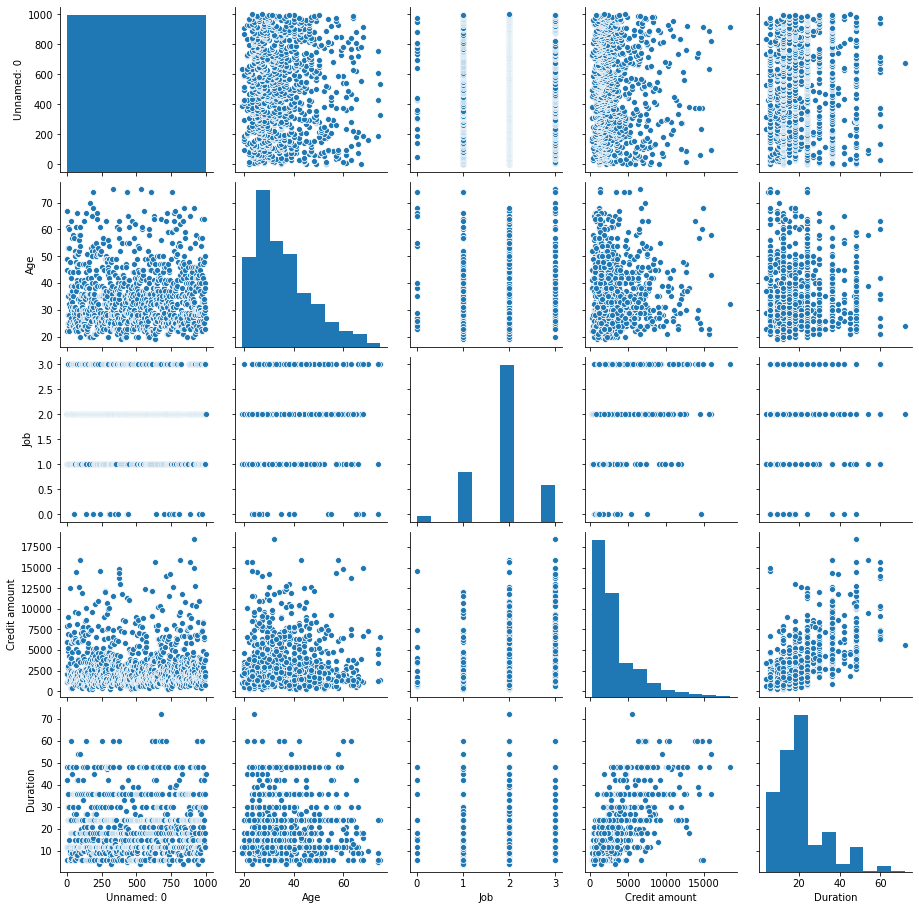

In [6]:
sns.pairplot(data);

In [7]:
data['Saving accounts'].unique()

array([nan, 'little', 'quite rich', 'rich', 'moderate'], dtype=object)

In [8]:
data['Checking account'].unique()

array(['little', 'moderate', nan, 'rich'], dtype=object)

In [9]:
#Let's replace NaNs with «None»
data['Saving accounts'] = data['Saving accounts'].fillna('None')
data['Checking account'] = data['Checking account'].fillna('None')

In [10]:
#drop the useless feature 
data.drop('Unnamed: 0', axis=1, inplace=True)
#create cat. vac.
categorical_features = ['Sex', 'Job', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']

In [11]:
#labelencode the cat features
for i, cat in enumerate(categorical_features):
    data[cat] = LabelEncoder().fit_transform(data[cat])

In [12]:
#lets normalize numerical features
num_features = data[['Age', 'Duration', 'Credit amount']]
num_features = np.log(num_features)

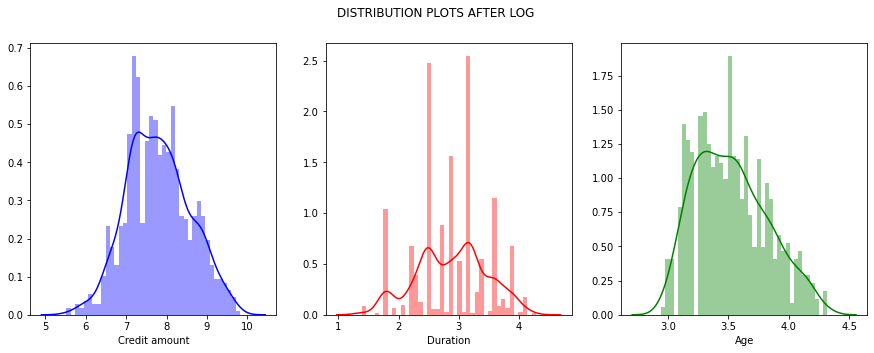

In [13]:
fig, ax = plt.subplots(1,3,figsize=(15,5))
plt.suptitle('DISTRIBUTION PLOTS AFTER LOG')
sns.distplot(num_features['Credit amount'], bins=40, ax=ax[0], color='blue');
sns.distplot(num_features['Duration'], bins=40, ax=ax[1], color='red');
sns.distplot(num_features['Age'], bins=40, ax=ax[2], color='green');

Why do we need to scale features?
Foe example if we will use SVM with Gaussian kernel.
An SVM takes this function and uses it to compare the similarity of a point X1
to every other point in the training set by summing the differences as:(x1−l1)²+(x2−l2)²...+(xn−ln)²
where x is your example and the values of l are the landmarks.
If the feature x1 ranges from 0 - 5000 while the feature x2 ranges from 0 - 0.01, you can see that x1 is going to dominate that sum while x2 will have virtually no impact. 
For this reason it is necessary to scale the features before applying to this kernel kernal.

# UMAP

In [17]:
import umap.umap_ as umap

In [25]:
umap_emb = umap.UMAP(n_components=2, min_dist=0.3, random_state=SEED, verbose=True)

In [26]:
X_umap = umap_emb.fit_transform(num_data_scaled)

UMAP(min_dist=0.3, random_state=4445, verbose=True)
Construct fuzzy simplicial set
Wed Feb 24 13:49:10 2021 Finding Nearest Neighbors
Wed Feb 24 13:49:10 2021 Finished Nearest Neighbor Search
Wed Feb 24 13:49:10 2021 Construct embedding
	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Feb 24 13:49:11 2021 Finished embedding


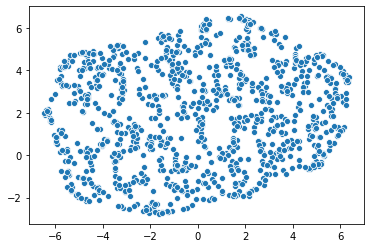

In [27]:
sns.scatterplot(X_umap[:,0], X_umap[:,1]);

# PCA

In [28]:
from sklearn.decomposition import PCA


In [40]:
pca = PCA(n_components=2, random_state = SEED)

In [41]:
X_pca = pca.fit_transform(num_data_scaled)

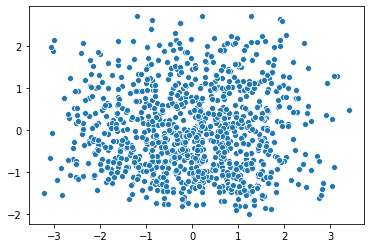

In [42]:
sns.scatterplot(X_pca[:,0], X_pca[:,1]);

# t-SNE

In [21]:
from sklearn.manifold import TSNE

In [22]:
tsne = TSNE(n_components=2, random_state=SEED)

In [23]:
X_tsne = tsne.fit_transform(num_data_scaled)

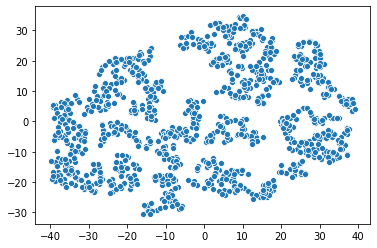

In [24]:
sns.scatterplot(X_tsne[:,0], X_tsne[:,1]);

# k-mean


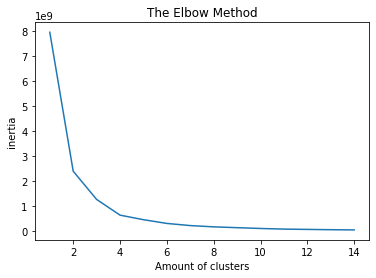

In [43]:
inertia = []
k = range(1, 15)
for k_i in k:
    km = KMeans(n_clusters=k_i).fit(data)
    inertia.append(km.inertia_)
    
plt.plot(k, inertia)
plt.xlabel('Amount of clusters')
plt.ylabel('inertia')
plt.title('The Elbow Method');

Optimal amount of clusters is about 3 or 4

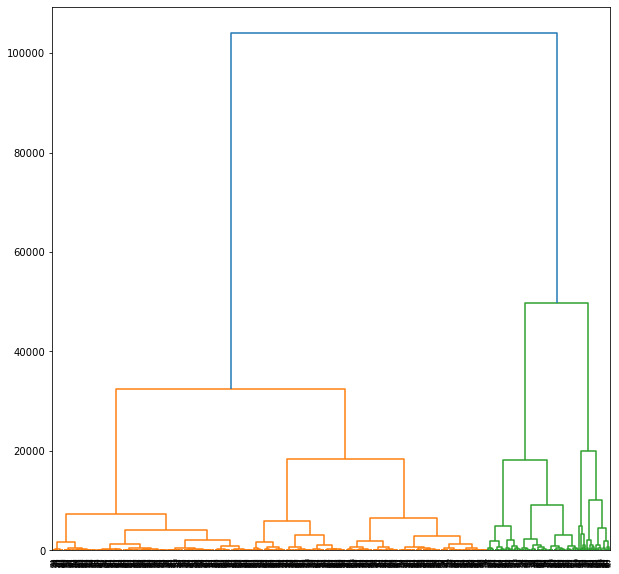

In [44]:
#building a dendogram
plt.figure(figsize=(10,10))
linkage_ = linkage(data, method='ward')
dendrogram_ = dendrogram(linkage_)

Optimal amount of clusters is 2,3 or 4

In [45]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = KMeans(n_clusters=i).fit(data)
    labels = agg.labels_
    score = silhouette_score(data, labels)
    silhouette.append(score)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 14.08it/s]


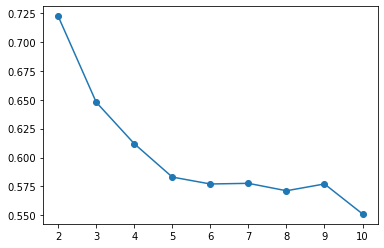

In [46]:
plt.plot(range(2,11), silhouette, marker='o');

In [47]:
#We will try 3 clusters
km = KMeans(n_clusters=3, random_state=SEED)
clusters = km.fit_predict(num_data_scaled)

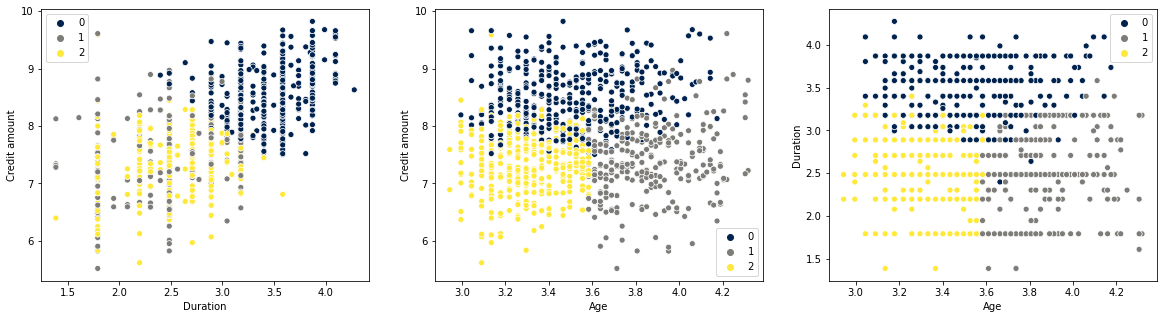

In [48]:
fig, ax  = plt.subplots(1,3,figsize=(20,5))
sns.scatterplot(num_features['Duration'], num_features['Credit amount'], hue=clusters, ax=ax[0], palette='cividis')
sns.scatterplot(num_features['Age'], num_features['Credit amount'], hue=clusters, ax=ax[1], palette='cividis')
sns.scatterplot(num_features['Age'], num_features['Duration'], hue=clusters, ax=ax[2], palette='cividis')

In [49]:
data_clustered = data[['Age', 'Duration', 'Credit amount']]
data_clustered['cluster'] = clusters

In [50]:
data_clustered.groupby('cluster').mean()

,Age,Duration,Credit amount
cluster,,,
0,34.042667,32.224000,5665.384000
1,48.498099,13.859316,1970.349810
2,27.693370,14.292818,1736.290055


0 — middle aged customers, 1 — old ,2 — young

In [93]:
labels = km.labels_

In [94]:
data['labels'] = labels

In [95]:
data['labels'].value_counts(normalize=True)

0    0.375
2    0.362
1    0.263
Name: labels, dtype: float64

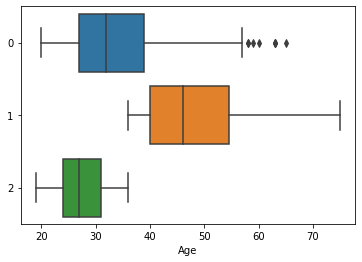

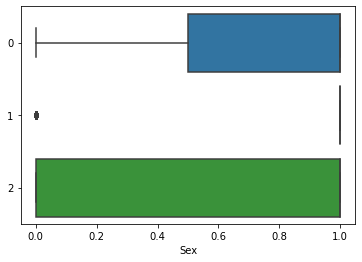

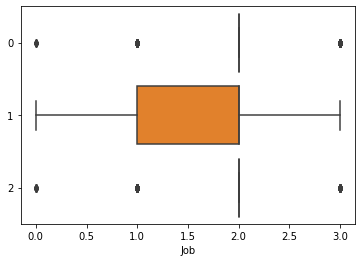

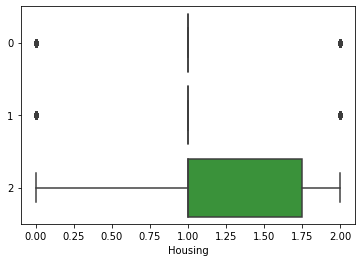

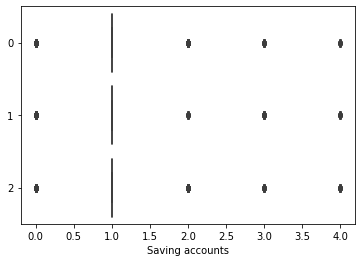

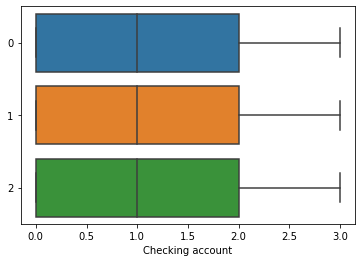

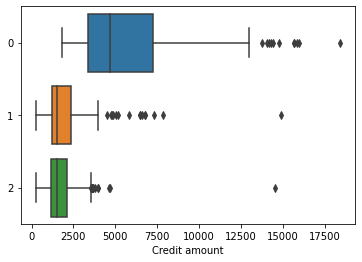

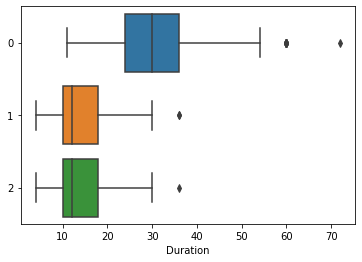

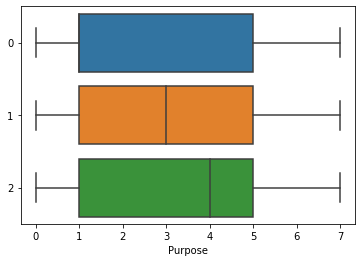

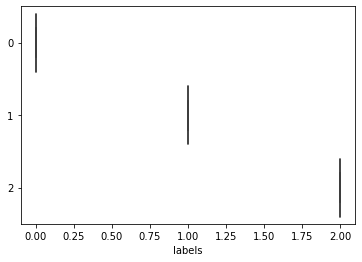

In [96]:
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();

In [97]:
data.groupby('labels').median().T.round()

labels,0,1,2
Age,32,46,27
Sex,1,1,1
Job,2,2,2
Housing,1,1,1
Saving accounts,1,1,1
Checking account,1,1,1
Credit amount,4686,1526,1503
Duration,30,12,12
Purpose,1,3,4


Как видно самые большие по суммам и срокам выдачи кредиты берут люди средних лет (в среднем 32 лет).
«Молодеж» чуть больше людей в возрасте берет. 
В основном мужчины с работой в категории «skilled»
Все имеют накопления.

# AgglomerativeClustering


In [51]:
silhouette = []
for i in tqdm(range(2,11)):
    agg = AgglomerativeClustering(n_clusters=i).fit(num_data_scaled)
    labels = agg.labels_
    score = silhouette_score(num_data_scaled, labels)
    silhouette.append(score)

100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 25.78it/s]


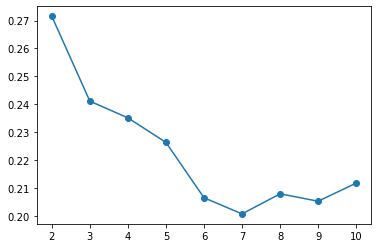

In [52]:
plt.plot(range(2,11), silhouette, marker='o');

In [53]:
agg = AgglomerativeClustering(n_clusters=3).fit(num_data_scaled)
labels = agg.labels_

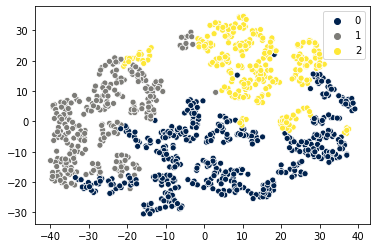

In [54]:
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=labels , palette='cividis')

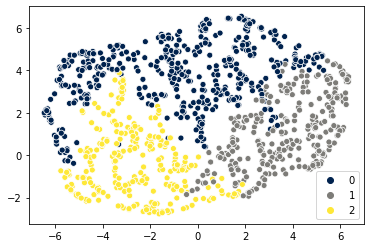

In [55]:
sns.scatterplot(X_umap[:,0], X_umap[:,1], hue=labels , palette='cividis')

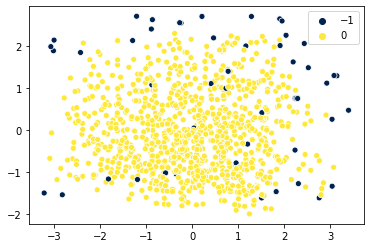

In [89]:
sns.scatterplot(X_pca[:,0], X_pca[:,1], hue=labels , palette='cividis')

In [56]:
data['labels'] = labels

In [57]:
data['labels'].value_counts(normalize=True)

0    0.455
1    0.277
2    0.268
Name: labels, dtype: float64

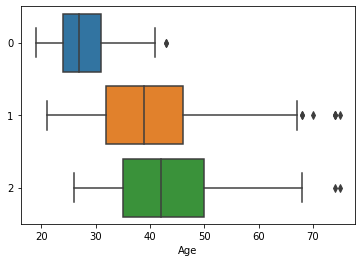

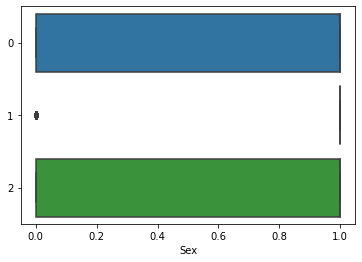

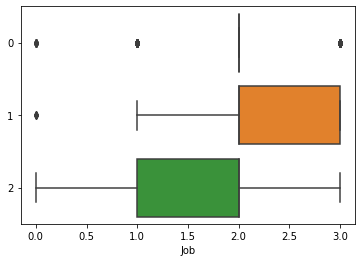

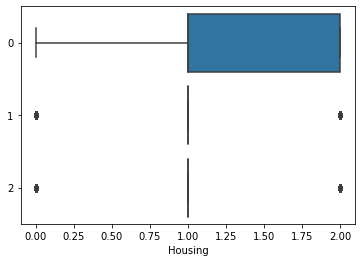

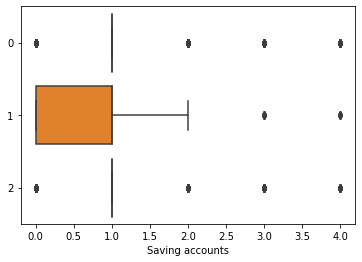

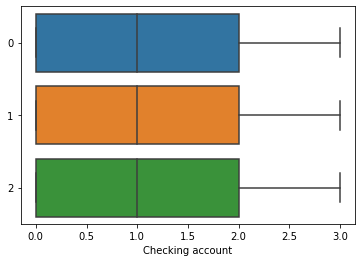

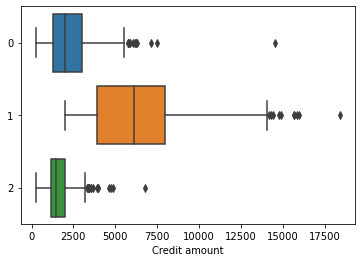

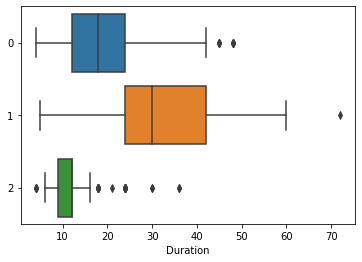

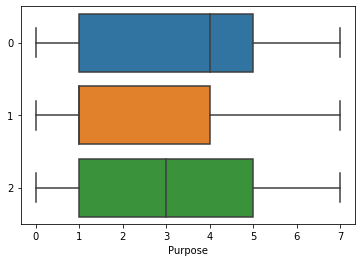

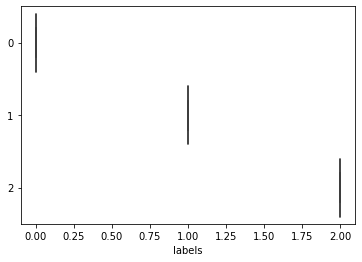

In [58]:
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();

In [59]:
data.groupby('labels').median().T.round()

labels,0,1,2
Age,27.0,39.0,42.0
Sex,1.0,1.0,1.0
Job,2.0,2.0,2.0
Housing,1.0,1.0,1.0
Saving accounts,1.0,1.0,1.0
Checking account,1.0,1.0,1.0
Credit amount,1967.0,6110.0,1430.0
Duration,18.0,30.0,12.0
Purpose,4.0,1.0,3.0


Как видно самые большие по суммам и срокам выдачи  кредиты берут люди средних лет (в среднем 39 лет). 
Молодеж чуть больше людей в возрасте берет. (хотя медиана по старшему возрасту на 3  больше среднего всего). В основном мужчины с работой
в категории «skilled»


# DBSCAN

In [60]:
#stolen)
def dbscan_clustering(eps_range, X):
    eps_range = eps_range
    silhouette = []
    clusters = []
    for i in tqdm(eps_range):
        dbscan = DBSCAN(eps=i).fit(X)
        labels = dbscan.labels_
        uniq_labels = np.unique(labels)
        n_clusters = len(uniq_labels[uniq_labels != -1])
        if n_clusters > 1:
            score = silhouette_score(X, labels)
        else:
            score = 0
        silhouette.append(score)
        clusters.append(n_clusters)
        
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.plot(eps_range, silhouette, marker='o', color=color)
    ax1.set_xlabel('eps')
    ax1.set_ylabel('silhouette', color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.plot(eps_range, clusters, marker='o', color=color)
    ax2.set_ylabel('n_clusters', color=color)  
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [00:01<00:00, 55.42it/s]


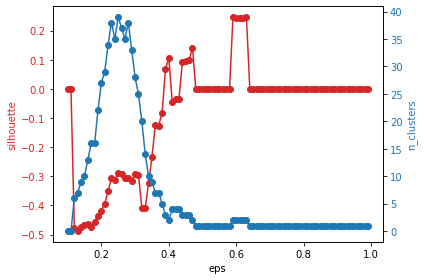

In [61]:
eps_range = np.arange(0.1,1,0.01)
dbscan_clustering(eps_range, num_data_scaled)

100%|██████████████████████████████████████████████████████████████████████████████████| 60/60 [00:01<00:00, 57.46it/s]


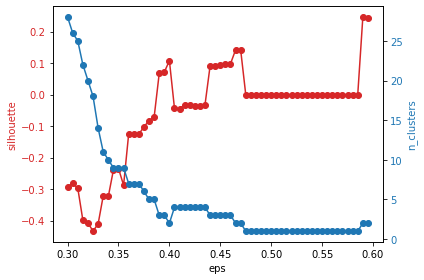

In [74]:
eps_range = np.arange(0.3,0.6,0.005)
dbscan_clustering(eps_range, num_data_scaled)

In [77]:
dbscan = DBSCAN(eps=0.58).fit( num_data_scaled)
labels = dbscan.labels_

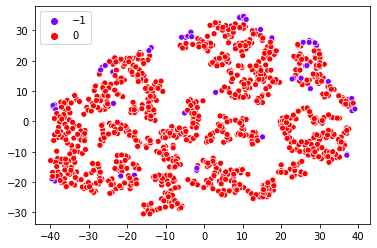

In [78]:
sns.scatterplot(X_tsne[:,0], X_tsne[:,1], hue=labels, palette='rainbow');

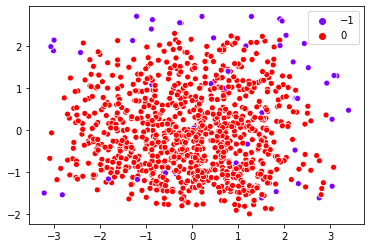

In [79]:
sns.scatterplot(X_pca[:,0], X_pca[:,1], hue=labels, palette='rainbow');

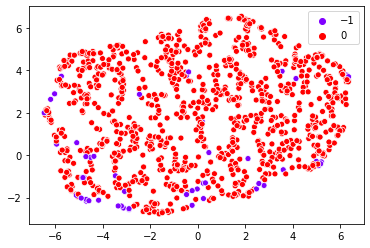

In [80]:
sns.scatterplot(X_umap[:,0], X_umap[:,1], hue=labels, palette='rainbow');

In [85]:
data['labels'] = labels

In [86]:
data['labels'].value_counts(normalize=True)

 0    0.949
-1    0.051
Name: labels, dtype: float64

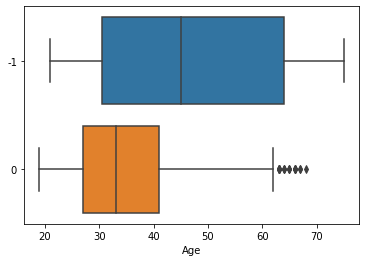

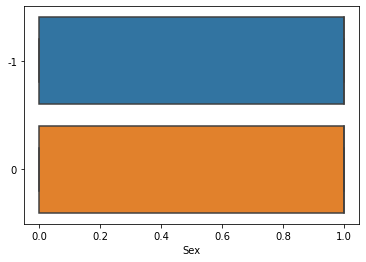

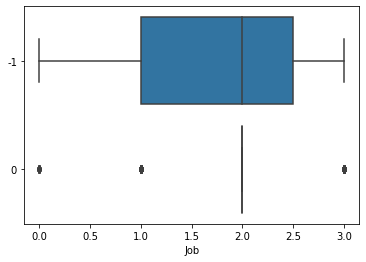

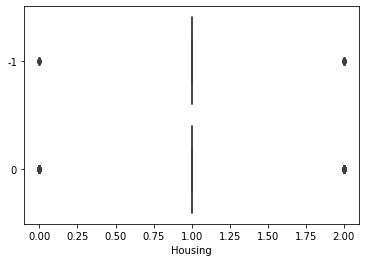

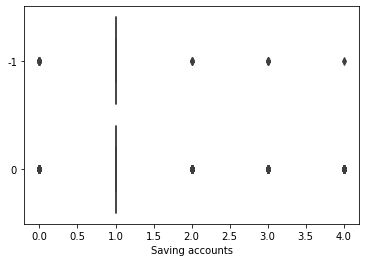

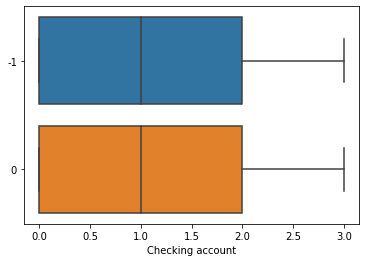

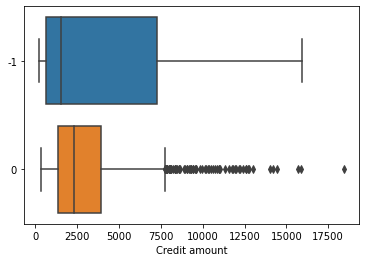

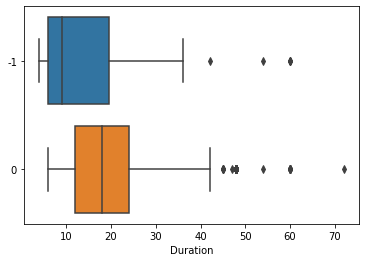

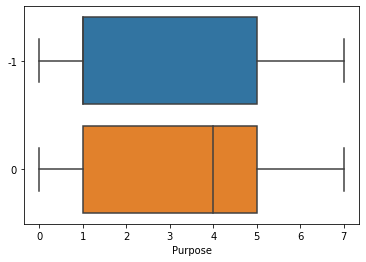

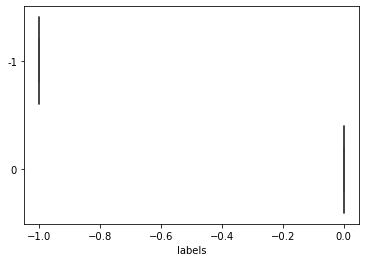

In [87]:
for col in data.columns:
    sns.boxplot(data=data, x=col, y=labels, orient='h')
    plt.show();

In [88]:
data.groupby('labels').median().T.round()

labels,-1,0
Age,45,33
Sex,1,1
Job,2,2
Housing,1,1
Saving accounts,1,1
Checking account,1,1
Credit amount,1544,2320
Duration,9,18
Purpose,1,4


In [ ]:
DBSCAN при eps=0.59 определил 2 кластера. (при данной эпсилон нет выбросов)
Как видно самые большие по суммам и срокам выдачи кредиты берут люди в возрасте около
«Молодеж» чуть больше людей в возрасте берет. 
В основном мужчины с работой в категории «skilled»
Все имеют накопления.

Вывод: думаю, что лучше всего отработал алгоритм K-means. Вывод данных выглядит более «равномерным» чем у других алгоритмов. 